# Introduction
This notebook aims to explore the use of Long Short-Term Memory (LSTM) networks for image classification, specifically employing Bi-directional LSTMs on the MNIST dataset. The MNIST dataset, a benchmark in the field of machine learning, consists of 70,000 grayscale images of handwritten digits, divided into 60,000 training images and 10,000 test images. Each image is 28x28 pixels in size, representing digits from 0 to 9.

LSTM networks, a type of recurrent neural network (RNN), are well-known for their ability to capture long-term dependencies in sequential data. Traditionally, LSTMs have been applied extensively in natural language processing (NLP) tasks such as language modeling and machine translation. However, their application to image classification presents a unique and interesting challenge.

The primary motivation behind using LSTMs for image classification is their capacity to sequentially process data. By treating each row or column of an image as a sequence, LSTMs can be used to capture spatial dependencies across pixels. A Bi-directional LSTM (BiLSTM) enhances this approach by processing sequences in both forward and backward directions, thereby providing a more comprehensive understanding of the spatial context.

In this notebook, we will:

- Preprocess the MNIST dataset: Prepare the data for input into the LSTM model by normalizing the pixel values and reshaping the images.
- Build the Bi-directional LSTM model: Design a neural network architecture that leverages the power of BiLSTMs for image classification.
- Train the model: Use the training set to train the BiLSTM model, optimizing it to recognize handwritten digits.
- Evaluate the model: Assess the model’s performance on the test set, analyzing metrics such as accuracy and loss.
- Visualize the results: Present visualizations of the model’s performance to gain insights into its strengths and areas for improvement.

By the end of this notebook, you will have a comprehensive understanding of how Bi-directional LSTMs can be utilized for image classification tasks, along with practical experience in implementing and evaluating such a model on the MNIST dataset.

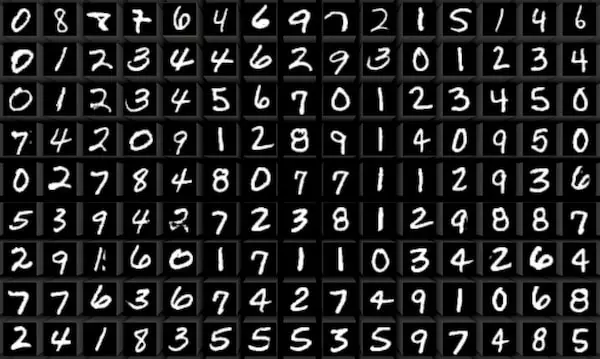

References:

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from copy import deepcopy
from tqdm import tqdm

plt.style.use('dark_background')

# Reproducability and Image Normalization

In [2]:
# Set random seed for reproducibility
random_seed = 1

# For reproducibility, this turns off cudnn's auto-tuner.
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size_train = 64
batch_size_test = 64
val_size = 5000

In [3]:
global_mean = 0.5 # MNIST train dataset mean
global_std = 0.5 # MNIST train dataset standard deviation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((global_mean), (global_std)),
])

In [4]:
data_path = 'datasets/mnst'

if not os.path.exists(data_path):
    download = True
else:
    download = False

train_dataset = torchvision.datasets.MNIST(
        data_path,
        train=True, 
        download=download,
        transform=transform,
        )

val_dataset = torchvision.datasets.MNIST(
        data_path,
        train=False, 
        download=download,
        transform=transform,
        )

# Splitting MNIST dataset into validation and test sets
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size_train,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size_test,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size_test,
    shuffle=False
)

Batch index: 0
Input batch shape: torch.Size([64, 1, 28, 28])
Target batch shape: torch.Size([64])


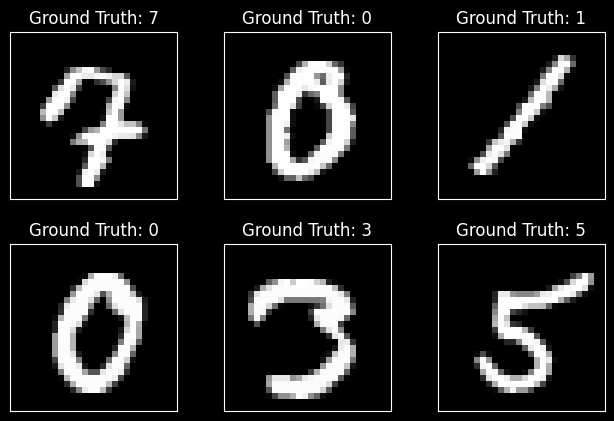

In [5]:
batch = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(batch)
print(f"Batch index: {batch_idx}")
print(f"Input batch shape: {example_data.shape}")
print(f"Target batch shape: {example_targets.shape}")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# Building the Bi-directional LSTM Model

In [6]:
def train_classification(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        x = x.squeeze(1) # Remove the channel dimension
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy


def validate_classification(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for (x, y) in data_loader:
            x, y = x.to(device), y.to(device)
            x = x.squeeze(1) # Remove the channel dimension
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

def evaluate_classification(model, data_loader, device):
    model.to(device).eval()
    correct = 0
    total_samples = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            x = x.squeeze(1) # Remove the channel dimension
            y_hat = model(x)
            predictions.append(y_hat.argmax(1))
            actuals.append(y)
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    actuals = torch.cat(actuals, dim=0).cpu().numpy()
    accuracy = 100.0 * correct / total_samples

    return predictions, actuals, accuracy

def inference_classification(model, x_batch, device):
    model.to(device).eval()
    predictions = []

    with torch.no_grad():
        x_batch = x_batch.to(device)
        x_batch = x_batch.squeeze(1) # Remove the channel dimension
        y_hat = model(x_batch)
        predictions.append(y_hat.argmax(dim=1))

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    return predictions

class EarlyStopper:
    def __init__(
        self, patience: int = 1, min_delta: float = 0.0, verbose: bool = False
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_model_weights = None
        self.verbose = verbose

    def early_stop(self, loss:float, model:nn.Module):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [7]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, n_features:int, hidden_size:int, output_size:int, num_layers:int=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.blstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        # We need to make this 2*hidden_size because the LSTM is bidirectional
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Shape: (batch, seq_len, n_features) -> (batch, seq_len, hidden_size), (h_n, c_n)
        x, _ = self.blstm(x)
        # Shape: (batch, seq_len, hidden_size) -> (batch, hidden_size) -> (batch, hidden_size)
        x = self.fc1(self.dropout1(x[:, -1, :]))
        # Shape: (batch, hidden_size) -> (batch, hidden_size)
        x = self.fc2(self.dropout2(F.relu(x)))
        return x

In [8]:
# Hyperparameters
n_features = 28
hidden_size = 256
num_layers = 2
output_size = 10

# Training Parameters
n_epochs = 3
patience = 1
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# instantiate model, loss function and optimizer
model = BiLSTMClassifier(n_features, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
early_stopper = EarlyStopper(patience=patience, min_delta=0.001)

In [9]:
# Lists to store loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
print_every = 1

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss, epoch_train_acc = train_classification(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    epoch_val_loss, epoch_val_acc = validate_classification(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)
    scheduler.step()

    if early_stopper.early_stop(epoch_val_loss, model):
        early_stopper.restore_best_weights(model)
        print("Early Stopping triggered: Restoring best weights")
        break

    if epoch % print_every == 0:
        print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.2f}% - Val loss: {epoch_val_loss:.4f} acc: {epoch_val_acc:.2f}%')

Training Progress:  33%|███▎      | 1/3 [00:21<00:42, 21.45s/it]

[1/3] Train loss: 0.3688 acc: 87.99% - Val loss: 0.1202 acc: 96.70%


Training Progress:  67%|██████▋   | 2/3 [00:42<00:21, 21.16s/it]

[2/3] Train loss: 0.0858 acc: 97.53% - Val loss: 0.0700 acc: 97.88%


Training Progress: 100%|██████████| 3/3 [01:03<00:00, 21.07s/it]

[3/3] Train loss: 0.0411 acc: 98.83% - Val loss: 0.0428 acc: 98.62%


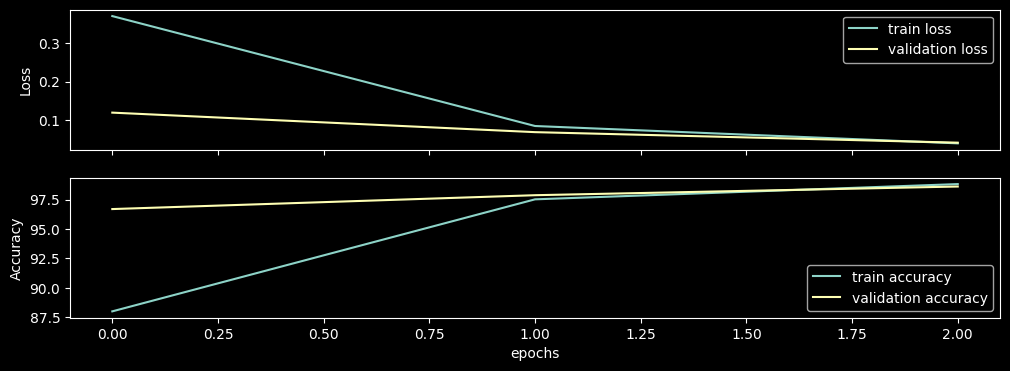

In [10]:
# plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 4), sharex=True)

ax1.plot(train_loss, label="train loss")
ax1.plot(val_loss, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_accuracy, label="train accuracy")
ax2.plot(val_accuracy, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()

# Evaluate Model

In [11]:
y_train_hat, y_train_actual, train_accuracy = evaluate_classification(model, train_loader, device)
y_val_hat, y_val_actual, val_accuracy = evaluate_classification(model, val_loader, device)
y_test_hat, y_test_actual, test_accuracy = evaluate_classification(model, test_loader, device)

In [12]:
print(f"Accuracy on test data: {test_accuracy:.2f}%")
print(f"The predictions are: {y_test_hat}")
print(f"The actual values are: {y_test_actual}")

Accuracy on test data: 98.78%
The predictions are: [8 4 2 ... 9 2 7]
The actual values are: [8 4 2 ... 9 2 7]


# Inference

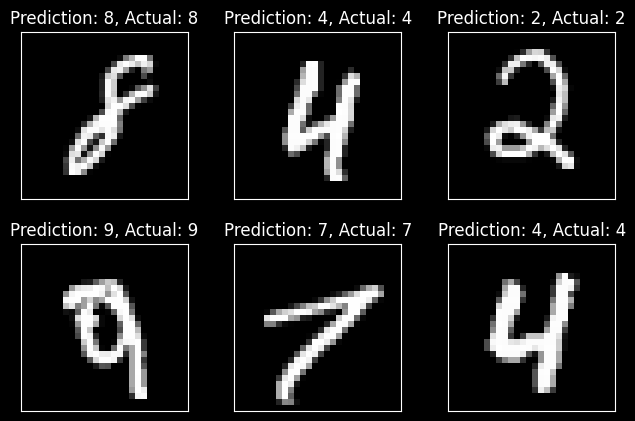

In [13]:
test_batch = next(iter(test_loader))
test_data, test_targets = test_batch

# Perform inference on the test dataset
y_test_hat = inference_classification(model, test_data, device)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(test_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Prediction: {y_test_hat[i]}, Actual: {test_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()